In [15]:
import os
from functools import reduce

import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.size"] = 12
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1

from matplotlib.colors import LinearSegmentedColormap

cm_data = np.loadtxt("../../ScientificColourMaps7/davos/davos.txt")[::-1]
scm_map = LinearSegmentedColormap.from_list("davos", cm_data)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

## SREX regions

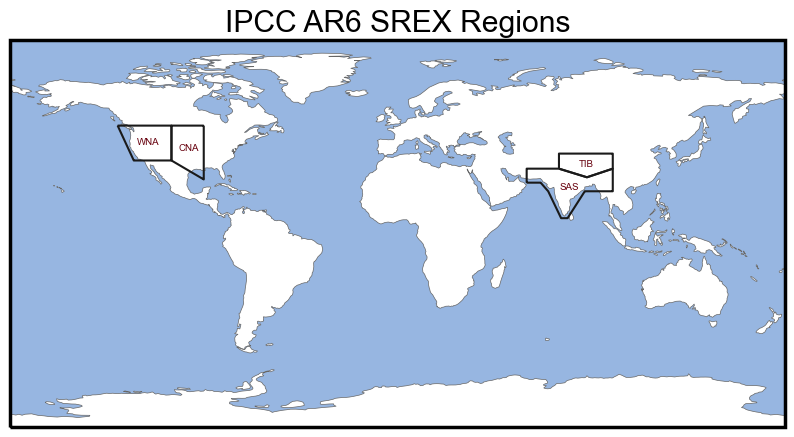

In [30]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

regions = ["WNA", "CNA", "SAS", "TIB"]

# Figure
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(10, 6), subplot_kw=dict(projection=ccrs.PlateCarree())
)

regionmask.defined_regions.ar6.land["WNA", "CNA", "SAS", "TIB"].plot(
    text_kws=text_kws, add_ocean=True, label="abbrev", ax=ax
)

ax.set_global()
ax.set_title("IPCC AR6 SREX Regions")
plt.savefig("../figs/supplementary/SREX_example.png", dpi=600)

## Interaction effects

In [25]:
##################################
# UC timeseries with interactions
##################################
def plot_uc_anova_timeseries(
    metric, var_id, city, deg, title, ylabel, xlabel, legend, ax
):
    """
    get_timeseries_latlon should have already been run, and ANOVA calculation should have already been
    done on R.
    """
    # Read ANOVA results
    df_anova = pd.read_csv(
        data_path
        + "anova_results/"
        + city
        + "_"
        + metric
        + "_"
        + var_id
        + "_forced_deg"
        + str(deg)
        + ".csv"
    )

    # Read raw and forced (for IAV calculation)
    df_raw = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
    df_forced = pd.read_csv(
        data_path
        + city
        + "_"
        + metric
        + "_"
        + var_id
        + "_forced_deg"
        + str(deg)
        + ".csv"
    )

    # Calculate IAV sum-of-squares
    df_raw = df_raw.rename(columns={var_id: var_id + "_raw"})
    df_forced = df_forced.rename(columns={var_id: var_id + "_forced"})

    df = pd.merge(
        df_raw, df_forced, on=["time", "ssp", "ensemble", "model"], how="inner"
    )
    df["variability"] = (df[var_id + "_raw"] - df[var_id + "_forced"]) ** 2
    df = df.groupby("time")[["variability"]].sum()

    # Merge
    df = pd.merge(df, df_anova, left_on="time", right_on="year", how="inner")

    # Get fractions
    df["total"] = df.apply(
        lambda x: x["variability"]
        + x["ssp"]
        + x["model"]
        + x["ensemble"]
        + x["ssp_model"]
        + x["model_ensemble"]
        + x["ssp_ensemble"],
        axis=1,
    )

    for uncertainty in [
        "variability",
        "ssp",
        "model",
        "ensemble",
        "ssp_model",
        "model_ensemble",
        "ssp_ensemble",
    ]:
        df[uncertainty] = 100 * df[uncertainty] / df["total"]

    df = df.sort_values(by="year")

    # Construct plotting dict
    uncert_dict = {
        "Scenario": df["ssp"].to_numpy(),
        "Model": df["model"].to_numpy(),
        "Downscaling": df["ensemble"].to_numpy(),
        "Variability": df["variability"].to_numpy(),
        "Model:Downscaling": df["model_ensemble"].to_numpy(),
        "Scenario:Downscaling": df["ssp_ensemble"].to_numpy(),
        "Scenario:Model": df["ssp_model"].to_numpy(),
    }

    # Make plot
    ax.stackplot(
        np.arange(2015, 2101),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=[
            "#7fc97f",
            "#beaed4",
            "#fdc086",
            "#ffff99",
            "#deb7ad",
            "#bec583",
            "#9fbcaa",
        ],
        edgecolor="white",
        lw=1.5,
    )

    if legend:
        ax.legend(
            loc="center left", ncol=2, columnspacing=0.6, handletextpad=0.1, fontsize=10
        )

    ax.set_xlim([2015, 2099])
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0, 100])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=11, loc="left")

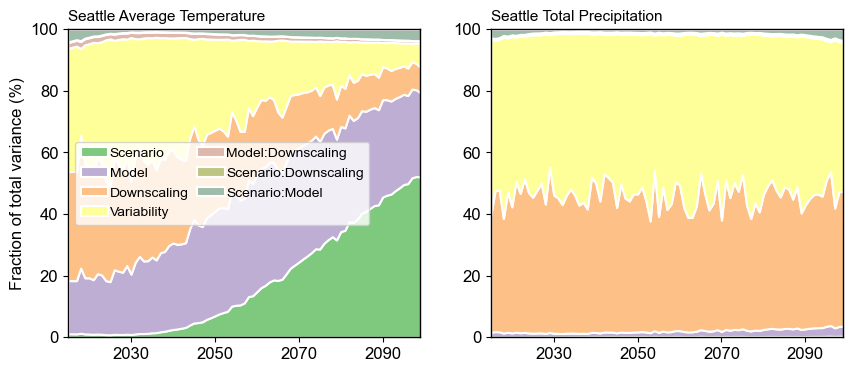

In [29]:
city = "seattle"
deg = 2

data_path = "/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/data/"

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_uc_anova_timeseries(
    "avg",
    "tas",
    city,
    deg,
    "Seattle Average Temperature",
    "Fraction of total variance (%)",
    "",
    True,
    axs[0],
)
plot_uc_anova_timeseries(
    "avg", "pr", city, deg, "Seattle Total Precipitation", "", "", False, axs[1]
)

plt.show()

## Checking the metrics

### Preliminaries

In [2]:
###################
# Models
###################
from utils import (
    cil_ssp_dict,
    deepsdbc_dict,
    gardsv_ssp_dict,
    gardsv_var_dict,
    isimip_ssp_dict,
    nex_ssp_dict,
)

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [
    model for model in cbp_gard_models if "pr" in gardsv_var_dict[model]
]
cbp_deep_models = list(deepsdbc_dict.keys())

In [ ]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    cores=1,
    memory="15GB",
    resource_spec="pmem=15GB",
    worker_extra_args=["#PBS -l feature=rhel7"],
    walltime="00:10:00",
)

cluster.scale(jobs=5)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

### Plots

In [3]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/"
path_out = "/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/figs/supplementary/"

In [12]:
def make_metric_plot(ensemble, model, ssps, path_in, metric, var_id, path_out):
    out_str = (
        path_out
        + metric
        + "/"
        + var_id
        + "/"
        + ensemble
        + "_"
        + model
        + "_"
        + metric
        + "_"
        + var_id
        + ".png"
    )
    if os.path.isfile(out_str):
        return "Already done"
    else:
        # Figure details
        fig, axs = plt.subplots(
            nrows=2,
            ncols=2,
            figsize=(10, 6),
            subplot_kw=dict(projection=ccrs.PlateCarree()),
        )
        axs = axs.flatten()

        fig.subplots_adjust(
            bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.01
        )

        fig.suptitle(
            ensemble + "_" + model + "_" + metric + "_" + var_id,
            fontsize=12,
            fontweight="bold",
            y=0.95,
        )

        # Read netcdf or zarr
        if ensemble in ["cil-gdpcir", "DeepSD-BC"]:
            ds = xr.open_dataset(
                path_in + ensemble + "/" + metric + "/" + model, engine="zarr"
            )
        elif ensemble == "isimip3b":
            ds = xr.open_dataset(path_in + metric + "/" + model + ".nc")
        else:
            ds = xr.open_dataset(
                path_in + ensemble + "/" + metric + "/" + model + ".nc"
            )

        # Slice
        ds = ds.sel(lat=slice(-60, 90))

        # Select variable
        if var_id in list(ds.data_vars):
            ds = ds[var_id]

        # Plot by ssp
        for idx, ssp in enumerate(ssps):
            # hard-code the one exception
            if (
                (ensemble == "DeepSD-BC")
                and (ssp == "ssp585")
                and (var_id == "pr")
                and (model == "MRI-ESM2-0")
            ):
                continue
            else:
                try:
                    p = (
                        ds.sel(ssp=ssp)
                        .isel(time=80)
                        .plot(
                            transform=ccrs.PlateCarree(),
                            add_colorbar=False,
                            ax=axs[idx],
                            levels=11,
                        )
                    )
                    axs[idx].set_title(ssp)
                    map_exists = True
                except:
                    axs[idx].set_title(ssp + " ERROR")
                    map_exists = False

        # Single colorbar
        if map_exists:
            cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.02])

            cbar = fig.colorbar(
                p, cax=cbar_ax, orientation="horizontal", label=metric + " " + var_id
            )

        plt.savefig(out_str, dpi=300)
        # plt.show()

In [9]:
%%time
################
# avg, max
###############
delayed_res = []
for metric in ["avg", "max"]:
    for var_id in ["tas", "tasmin", "tasmax", "pr"]:
        # NEX
        for model in nex_models:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "nex-gddp",
                    model,
                    nex_ssp_dict[model],
                    path_in,
                    metric,
                    var_id,
                    path_out,
                )
            )

        # CIL
        for model in cil_models:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "cil-gdpcir",
                    model,
                    cil_ssp_dict[model],
                    path_in,
                    metric,
                    var_id,
                    path_out,
                )
            )

        # ISIMIP
        for model in isi_models:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "isimip3b",
                    model,
                    isimip_ssp_dict[model],
                    path_in + "isimip3b/regridded/conservative/",
                    metric,
                    var_id,
                    path_out,
                )
            )

        # GARD-SV
        if var_id == "pr":
            model_list = cbp_gard_precip_models
        else:
            model_list = cbp_gard_models
        for model in model_list:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "GARD-SV",
                    model,
                    gardsv_ssp_dict[model],
                    path_in + "carbonplan/regridded/conservative/",
                    metric,
                    var_id,
                    path_out,
                )
            )

        # DeepSD-BC
        for model in cbp_deep_models:
            delayed_res.append(
                dask.delayed(make_metric_plot)(
                    "DeepSD-BC",
                    model,
                    deepsdbc_dict[model].keys(),
                    path_in + "carbonplan/native_grid/",
                    metric,
                    var_id,
                    path_out,
                )
            )

################
# max5d
#################
metric = "max5d"
var_id = "RX5day"

# NEX
for model in nex_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)(
            "nex-gddp", model, nex_ssp_dict[model], path_in, metric, var_id, path_out
        )
    )

# CIL
for model in cil_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)(
            "cil-gdpcir", model, cil_ssp_dict[model], path_in, metric, var_id, path_out
        )
    )

# ISIMIP
for model in isi_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)(
            "isimip3b",
            model,
            isimip_ssp_dict[model],
            path_in + "isimip3b/regridded/conservative/",
            metric,
            var_id,
            path_out,
        )
    )

# GARD-SV
for model in cbp_gard_precip_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)(
            "GARD-SV",
            model,
            gardsv_ssp_dict[model],
            path_in + "carbonplan/regridded/conservative/",
            metric,
            var_id,
            path_out,
        )
    )

# DeepSD-BC
for model in cbp_deep_models:
    delayed_res.append(
        dask.delayed(make_metric_plot)(
            "DeepSD-BC",
            model,
            deepsdbc_dict[model].keys(),
            path_in + "carbonplan/native_grid/",
            metric,
            var_id,
            path_out,
        )
    )

#############
# dry
#############
metric = "dry"

for var_id in ["count_eq_0", "count_lt_1", "streak_eq_0", "streak_lt_1"]:
    # NEX
    for model in nex_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "nex-gddp",
                model,
                nex_ssp_dict[model],
                path_in,
                metric,
                var_id,
                path_out,
            )
        )

    # CIL
    for model in cil_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "cil-gdpcir",
                model,
                cil_ssp_dict[model],
                path_in,
                metric,
                var_id,
                path_out,
            )
        )

    # ISIMIP
    for model in isi_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "isimip3b",
                model,
                isimip_ssp_dict[model],
                path_in + "isimip3b/regridded/conservative/",
                metric,
                var_id,
                path_out,
            )
        )

    # GARD-SV
    for model in cbp_gard_precip_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "GARD-SV",
                model,
                gardsv_ssp_dict[model],
                path_in + "carbonplan/regridded/conservative/",
                metric,
                var_id,
                path_out,
            )
        )

    # DeepSD-BC
    for model in cbp_deep_models:
        delayed_res.append(
            dask.delayed(make_metric_plot)(
                "DeepSD-BC",
                model,
                deepsdbc_dict[model].keys(),
                path_in + "carbonplan/native_grid/",
                metric,
                var_id,
                path_out,
            )
        )


# Compute
print(len(delayed_res))
res = dask.compute(*delayed_res)

701
CPU times: user 1.73 s, sys: 123 ms, total: 1.85 s
Wall time: 8.49 s


## Observational dataset comparison

### Preliminaries

In [2]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    cores=1,
    memory="15GB",
    resource_spec="pmem=15GB",
    worker_extra_args=["#PBS -l feature=rhel7"],
    walltime="01:00:00",
)

cluster.scale(jobs=40)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.239:33537,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Computations

In [6]:
%%time
##############
### GMFD
##############
in_path = "/gpfs/group/kaf26/default/rls66/GMFD_25/"
out_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/gmfd/"

# Read all
ds_tmin = xr.open_mfdataset(in_path + "tmin_daily_*", parallel=True, chunks="auto")
ds_tmin -= 273.15  # K -> C

ds_tmax = xr.open_mfdataset(in_path + "tmax_daily_*", parallel=True, chunks="auto")
ds_tmax -= 273.15  # K -> C

ds_pr = xr.open_mfdataset(in_path + "prcp_daily_*", parallel=True, chunks="auto")
ds_pr *= 86400  # kg m-2 s-1 -> mm/day

# Select time period
ds_tmin = ds_tmin.sel(time=slice("1980-01-01", "2014-12-31"))
ds_tmax = ds_tmax.sel(time=slice("1980-01-01", "2014-12-31"))
ds_pr = ds_pr.sel(time=slice("1980-01-01", "2014-12-31"))

# Get tasavg
ds_tas = (ds_tmin["tmin"] + ds_tmax["tmax"]) / 2.0

# Merge
ds = xr.merge([xr.Dataset({"tas": ds_tas}), ds_tmin, ds_tmax, ds_pr])

# Resample to annual
ds_avg = ds.resample(time="1Y").mean()
ds_max = ds.resample(time="1Y").max()

# Merge and store
ds_out = xr.merge(
    [
        ds_avg.rename(
            {
                "tas": "tas_avg",
                "tmax": "tasmax_avg",
                "tmin": "tasmin_avg",
                "prcp": "pr_avg",
            }
        ),
        ds_max.rename(
            {
                "tas": "tas_max",
                "tmax": "tasmax_max",
                "tmin": "tasmin_max",
                "prcp": "pr_max",
            }
        ),
    ]
)

ds_out["lon"] = np.where(
    ds_out["lon"] > 180, ds_out["lon"] - 360, ds_out["lon"]
)  # update lon
ds_out = ds_out.sortby("lon")

ds_out.to_netcdf(out_path + "gmfd_annual.nc")

CPU times: user 2min 14s, sys: 5.7 s, total: 2min 20s
Wall time: 6min 17s


In [3]:
##############
### W5E5 v2.0
##############
in_path = "/gpfs/group/kaf26/default/dcl5300/W5E5v2/"
out_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/w5e5/"

# Read all
ds_tas = xr.open_mfdataset(in_path + "tas_*.nc", parallel=True, chunks="auto")
ds_tas -= 273.15  # K -> C

ds_tmax = xr.open_mfdataset(in_path + "tasmax_*.nc", parallel=True, chunks="auto")
ds_tmax -= 273.15  # K -> C

ds_tmin = xr.open_mfdataset(in_path + "tasmin_*.nc", parallel=True, chunks="auto")
ds_tmin -= 273.15  # K -> C

ds_pr = xr.open_mfdataset(in_path + "pr_*.nc", parallel=True, chunks="auto")
ds_pr *= 86400  # kg m-2 s-1 -> mm/day

# Select time period
ds_tas = ds_tas.sel(time=slice("1980-01-01", "2014-12-31"))
ds_tmin = ds_tmin.sel(time=slice("1980-01-01", "2014-12-31"))
ds_tmax = ds_tmax.sel(time=slice("1980-01-01", "2014-12-31"))
ds_pr = ds_pr.sel(time=slice("1980-01-01", "2014-12-31"))

# Merge
ds = xr.merge([ds_tas, ds_tmin, ds_tmax, ds_pr])

# Resample to annual
ds_avg = ds.resample(time="1Y").mean()
ds_max = ds.resample(time="1Y").max()

# Merge and store
ds_out = xr.merge(
    [
        ds_avg.rename(
            {
                "tas": "tas_avg",
                "tasmax": "tasmax_avg",
                "tasmin": "tasmin_avg",
                "pr": "pr_avg",
            }
        ),
        ds_max.rename(
            {
                "tas": "tas_max",
                "tasmax": "tasmax_max",
                "tasmin": "tasmin_max",
                "pr": "pr_max",
            }
        ),
    ]
)

ds_out.to_netcdf(out_path + "w5e5_annual.nc")

In [6]:
%%time
##############
### Regridding
##############
read_path = (
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/"
)

ds_gmfd = xr.open_dataset(read_path + "gmfd/gmfd_annual.nc")
ds_w5e5 = xr.open_dataset(read_path + "w5e5/w5e5_annual.nc")

ds_era5_temp = xr.open_dataset(read_path + "era5/annual/temperature", engine="zarr")
ds_era5_pr = xr.open_dataset(read_path + "era5/annual/precip", engine="zarr")

# Regrid to model metrics
out_grid = xr.open_dataset(
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/avg/ACCESS-ESM1-5.nc"
)

land_mask = out_grid.isel(time=0, ssp=0).tas.isnull().drop(["ssp", "time"])

out_grid = xr.Dataset({"lat": out_grid.lat, "lon": out_grid.lon})

## xESMF conservative regridder
# GMFD
cons_regridder = xe.Regridder(ds_gmfd, out_grid, "conservative", periodic=True)
ds_gmfd_cons = cons_regridder(ds_gmfd)

ds_gmfd_cons = xr.where(land_mask, np.nan, ds_gmfd_cons)

ds_gmfd_cons.to_netcdf(read_path + "gmfd/gmfd_annual_regridded.nc")

# W5E5
cons_regridder = xe.Regridder(ds_w5e5, out_grid, "conservative", periodic=True)
ds_w5e5_cons = cons_regridder(ds_w5e5)

ds_w5e5_cons = xr.where(land_mask, np.nan, ds_w5e5_cons)

ds_w5e5_cons.to_netcdf(read_path + "w5e5/w5e5_annual_regridded.nc")

# ERA5
ds_era5 = xr.merge([ds_era5_temp, ds_era5_pr])

cons_regridder = xe.Regridder(ds_era5, out_grid, "conservative", periodic=True)
ds_era5_cons = cons_regridder(ds_era5)

ds_era5_cons = xr.where(land_mask, np.nan, ds_era5_cons)

ds_era5_cons.to_netcdf(read_path + "era5/era5_annual_regridded.nc")

/storage/work/d/dcl5300/ENVS/micromamba/envs/climate-stack-mamba-2023-01/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


CPU times: user 2min 35s, sys: 6.49 s, total: 2min 41s
Wall time: 2min 47s


### Plots

In [5]:
################
# Cities
################
city_list = {
    "chicago": [41.881944, -87.627778],
    "lagos": [6.455027, 3.384082],
    "cairo": [30.044444, 31.235833],
    "seattle": [47.609722, -122.333056],
    "delhi": [28.613895, 77.209006],
    "houston": [29.762778, -95.383056],
    "mexicocity": [19.433333, -99.133333],
    "denver": [39.7392, -104.985],
    "nyc": [40.712778, -74.006111],
}

In [6]:
def fix_lon(ds):
    ds["lon"] = np.where(ds["lon"] > 180, ds["lon"] - 360, ds["lon"])
    return ds.sortby("lon")

In [7]:
# Read all
read_path = (
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/annual/"
)

ds_gmfd = fix_lon(xr.open_dataset(read_path + "gmfd/gmfd_annual_regridded.nc"))
ds_gmfd = ds_gmfd.assign_coords(obs="GMFD")

ds_w5e5 = fix_lon(xr.open_dataset(read_path + "w5e5/w5e5_annual_regridded.nc"))
ds_w5e5 = ds_w5e5.assign_coords(obs="W5E5")

ds_era5 = fix_lon(xr.open_dataset(read_path + "era5/era5_annual_regridded.nc"))
ds_era5 = ds_era5.assign_coords(obs="ERA5")

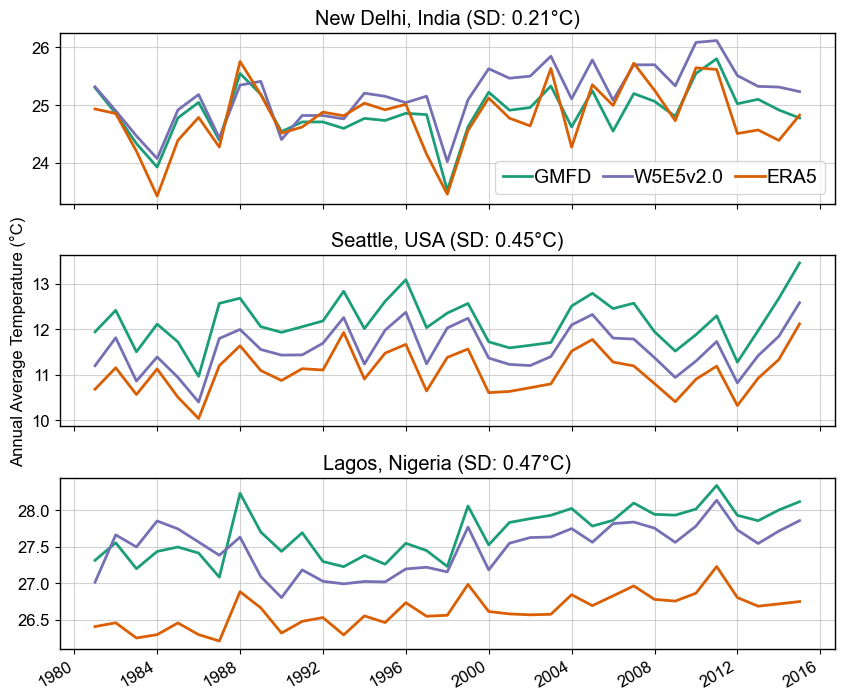

In [6]:
# Figure 1: average temperature
fig, axs = plt.subplots(
    3, 1, figsize=(10, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0.3}
)

color_dict = {"GMFD": "#1b9e77", "ERA5": "#d95f02", "W5E5": "#7570b3"}

### New Delhi, India
ax = axs[0]
lat, lon = city_list["delhi"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("New Delhi, India (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1)
ax.set_xlim(ax.get_xlim())
ax.plot([100, 200], [100, 200], color=color_dict["GMFD"], lw=2, label="GMFD")
ax.plot([100, 200], [100, 200], color=color_dict["W5E5"], lw=2, label="W5E5v2.0")
ax.plot([100, 200], [100, 200], color=color_dict["ERA5"], lw=2, label="ERA5")
ax.legend(fontsize=14, ncols=3, columnspacing=0.6, handletextpad=0.1, handlelength=1.5)

### Seattle, USA
ax = axs[1]
lat, lon = city_list["seattle"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Seattle, USA (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("Annual Average Temperature " + "(\N{DEGREE SIGN}C)")


### Lagos, Nigeria
ax = axs[2]
lat, lon = city_list["lagos"]
ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg.plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)

# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").tas_avg,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Lagos, Nigeria (SD: {sd:.2f}".format(sd=sd) + "\N{DEGREE SIGN}C)")

ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

plt.savefig("../figs/SIfig1a.png", dpi=600)

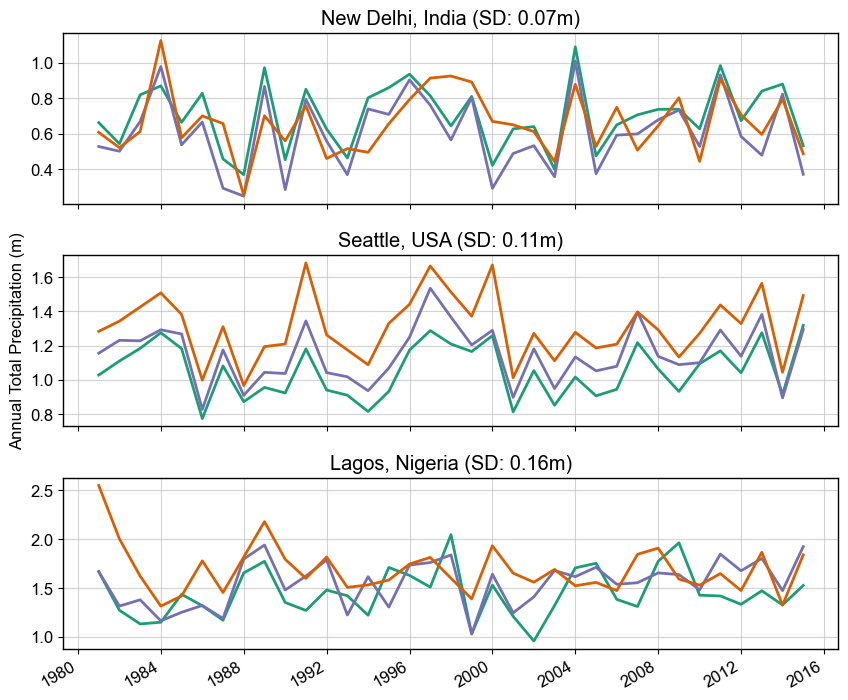

In [7]:
# Figure 1: average precip
fig, axs = plt.subplots(
    3, 1, figsize=(10, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0.3}
)

color_dict = {"GMFD": "#1b9e77", "ERA5": "#d95f02", "W5E5": "#7570b3"}

### New Delhi, India
ax = axs[0]
lat, lon = city_list["delhi"]
(ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
(ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
(ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)
# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("New Delhi, India (SD: {sd:.2f}m)".format(sd=sd))
ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

### Seattle, USA
ax = axs[1]
lat, lon = city_list["seattle"]
(ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
(ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
(ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)
# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Seattle, USA (SD: {sd:.2f}m)".format(sd=sd))
ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("Annual Total Precipitation (m)")

### Lagos, Nigeria
ax = axs[2]
lat, lon = city_list["lagos"]
(ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["GMFD"]
)
(ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["W5E5"]
)
(ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000).plot(
    ax=ax, label=None, lw=2, color=color_dict["ERA5"]
)
# SD calculation
sd = (
    xr.concat(
        [
            ds_gmfd.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_w5e5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
            ds_era5.sel(lat=lat, lon=lon, method="nearest").pr_avg * 365 / 1000,
        ],
        dim="obs",
    )
    .std(dim="obs")
    .mean(dim="time")
)
ax.set_title("Lagos, Nigeria (SD: {sd:.2f}m)".format(sd=sd))
ax.set_xlabel("")
ax.grid(color="silver", alpha=0.7)
ax.set_ylabel("")

plt.savefig("../figs/SIfig1b.png", dpi=600)

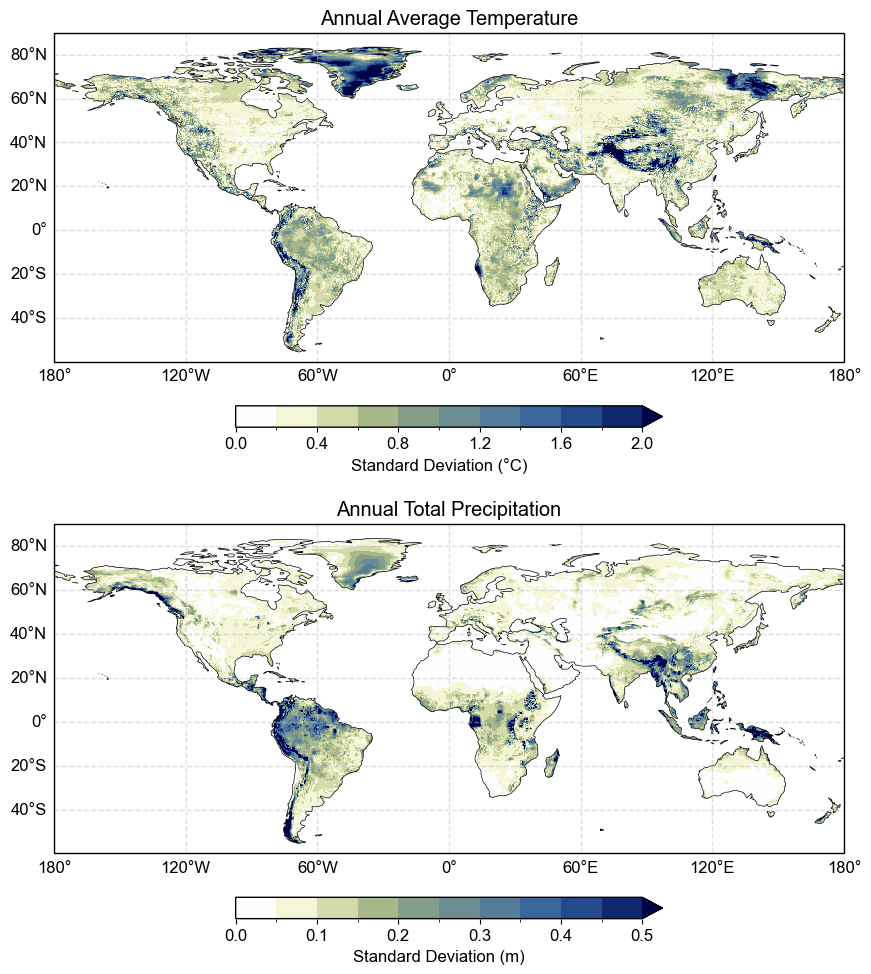

In [16]:
fig, axs = plt.subplots(
    ncols=1, nrows=2, figsize=(9, 10), subplot_kw=dict(projection=ccrs.PlateCarree())
)

## Average temperature map
# Merge
ds_all = xr.concat([ds_gmfd.tas_avg, ds_era5.tas_avg, ds_w5e5.tas_avg], dim="obs")
# Variance across obs, averaged over time
ds_all_std = ds_all.std(dim="obs").mean(dim="time")

ds_all_std.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    vmin=0.0,
    vmax=2.0,
    zorder=1,
    levels=11,
    cmap=scm_map,
    add_colorbar=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": "Standard Deviation " + "(\N{DEGREE SIGN}C)",
        "shrink": 0.5,
        "pad": 0.1,
    },
)
axs[0].set_title("Annual Average Temperature")

## Precipitation map
# Merge
ds_all = xr.concat([ds_gmfd.pr_avg, ds_era5.pr_avg, ds_w5e5.pr_avg], dim="obs")
# Variance across obs, averaged over time
ds_all_std = ds_all.std(dim="obs").mean(dim="time")

(ds_all_std * 365 / 1000).plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    vmin=0.0,
    vmax=0.5,
    cmap=scm_map,
    zorder=1,
    levels=11,
    add_colorbar=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": "Standard Deviation (m)",
        "shrink": 0.5,
        "pad": 0.1,
    },
)
axs[1].set_title("Annual Total Precipitation")

for ax in axs:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels={"bottom": "x", "left": "y"},
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )

plt.tight_layout()
plt.savefig("../figs/SIfig2.png", dpi=600)

## Historical quantile comparison

In [18]:
# Read all
era5_temp = xr.open_dataset(
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/quantiles/era5_temperature_quantiles_gardsv/",
    engine="zarr",
)
era5_prcp = xr.open_dataset(
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/quantiles/era5_precip_quantiles_gardsv/",
    engine="zarr",
)

gmfd_temp = xr.open_dataset(
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/quantiles/gmfd_temperature_quantiles_gardsv.nc"
)
gmfd_prcp = xr.open_dataset(
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/obs_data/quantiles/gmfd_precip_quantiles_gardsv.nc"
)

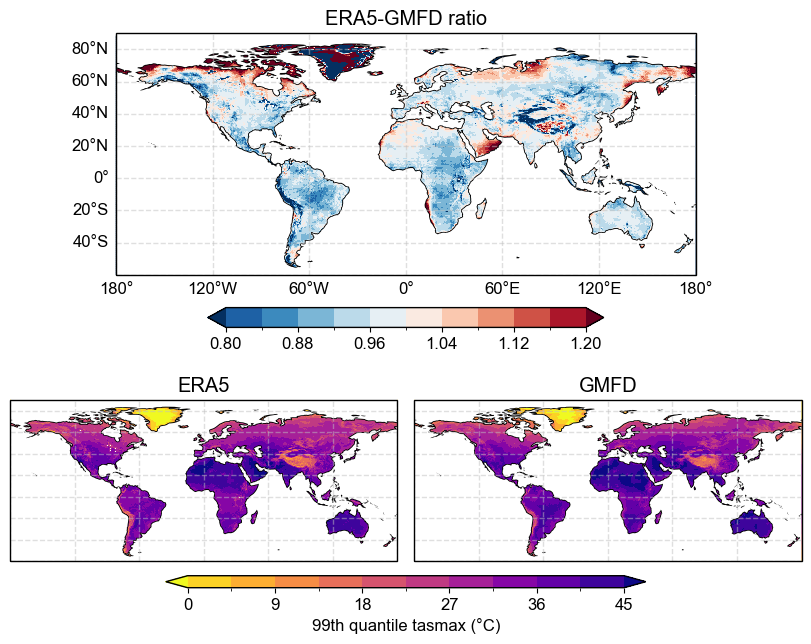

In [23]:
# 99th tasmax temperature quantiles
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(
    2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01
)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_temp.tasmax_q99 / gmfd_temp.tasmax_q99).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.8,
    vmax=1.2,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5-GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_temp.tasmax_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="plasma_r",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_temp.tasmax_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="plasma_r",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="99th quantile tasmax " + "(\N{DEGREE SIGN}C)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.show()

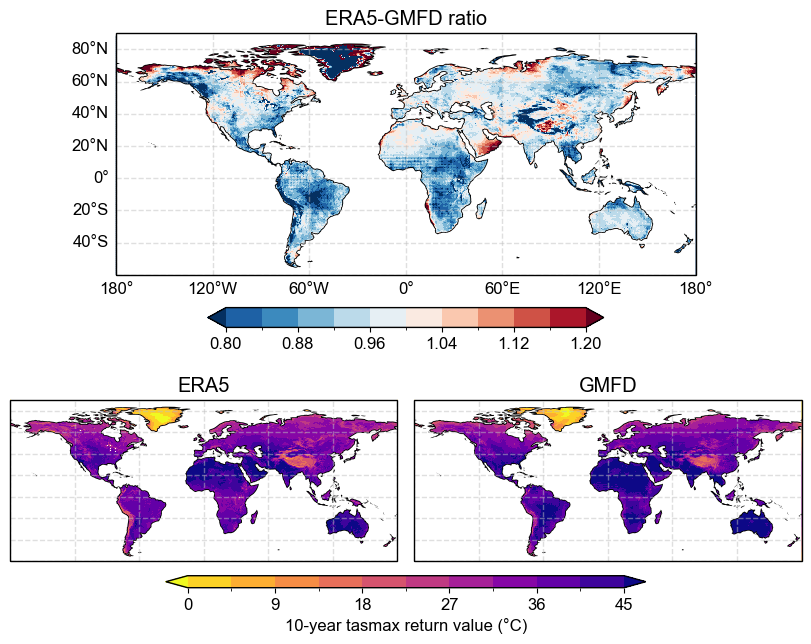

In [24]:
# 10-year tasmax return period
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(
    2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01
)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_temp.tasmax_rp10 / gmfd_temp.tasmax_rp10).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.8,
    vmax=1.2,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5-GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_temp.tasmax_rp10.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="plasma_r",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_temp.tasmax_rp10.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="plasma_r",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="10-year tasmax return value " + "(\N{DEGREE SIGN}C)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.show()

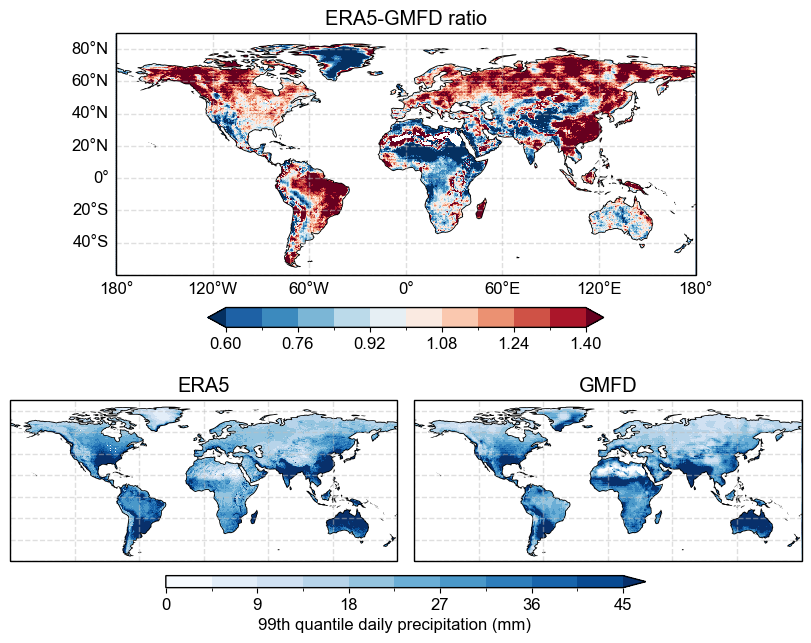

In [21]:
# 99th precip quantiles
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(
    2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01
)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_prcp.pr_q99 / gmfd_prcp.pr_q99).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.6,
    vmax=1.4,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5-GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_prcp.pr_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="Blues",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_prcp.pr_q99.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="Blues",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="99th quantile daily precipitation (mm)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.show()

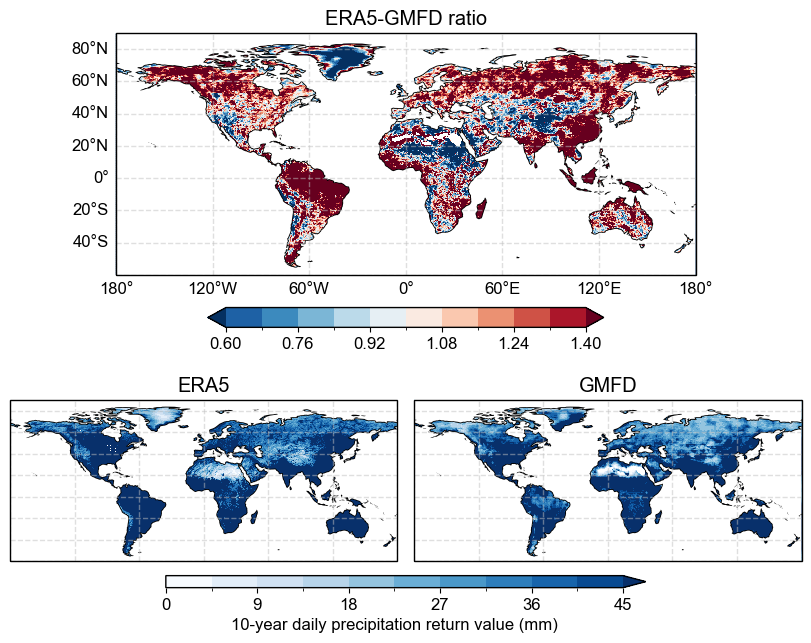

In [22]:
# 99th precip quantiles
fig = plt.figure(figsize=(8, 6), layout="constrained")

spec = fig.add_gridspec(
    2, 2, bottom=0.3, top=0.9, left=0.1, right=0.9, wspace=0.00, hspace=0.01
)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_prcp.pr_rp10 / gmfd_prcp.pr_rp10).sel(lat=slice(-60, 90))
ratio.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=0.6,
    vmax=1.4,
    cmap="RdBu_r",
    levels=11,
    zorder=1,
    cbar_kwargs={
        "orientation": "horizontal",
        "label": None,
        "shrink": 0.5,
        "pad": 0.04,
    },
)
ax0.coastlines()
ax0.set_title("ERA5-GMFD ratio")

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_prcp.pr_rp10.sel(lat=slice(-60, 90)).plot(
    ax=ax10,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="Blues",
)
ax10.set_title("ERA5")
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_prcp.pr_rp10.sel(lat=slice(-60, 90)).plot(
    ax=ax11,
    transform=ccrs.PlateCarree(),
    levels=11,
    zorder=1,
    add_colorbar=False,
    vmin=0,
    vmax=45,
    cmap="Blues",
)

ax11.set_title("GMFD")
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.03, 0.6, 0.02])

cbar = fig.colorbar(
    p,
    cax=cbar_ax,
    orientation="horizontal",
    label="10-year daily precipitation return value (mm)",
)

# Gridlines
for ax in [ax10, ax11]:
    ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=False,
        linewidth=1,
        color="silver",
        alpha=0.5,
        linestyle="--",
    )


ax0.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
ax0.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="silver",
    alpha=0.5,
    linestyle="--",
)

plt.show()

## Example plots

In [2]:
###################
# Models
###################
from utils import (
    cil_ssp_dict,
    deepsdbc_dict,
    gardsv_ssp_dict,
    gardsv_var_dict,
    isimip_ssp_dict,
    nex_ssp_dict,
)

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [
    model for model in cbp_gard_models if "pr" in gardsv_var_dict[model]
]
cbp_deep_models = list(deepsdbc_dict.keys())

In [32]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
nex_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/"
cil_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/cil-gdpcir/"
isi_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/regridded/conservative/"
cbp_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/carbonplan/"

out_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/"
poly_path = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/forced_response_polynomial/"

In [33]:
def read_and_process(
    ensemble, path_in, model, metric, submetric, submetric_var, lat, lon
):
    # Read netcdf or zarr
    if ensemble in ["NEX", "ISIMIP", "GARD-SV"]:
        ds = xr.open_dataset(path_in + metric + "/" + model + ".nc")
    elif ensemble in ["CIL", "DeepSD-BC"]:
        ds = xr.open_dataset(path_in + metric + "/" + model, engine="zarr")

    # Select submetric if chosen
    if submetric:
        ds = ds[submetric]

    # Common preprocessing
    ds["time"] = ds.indexes["time"].year
    if ds.lon.max() > 180:
        ds["lon"] = np.where(ds["lon"] > 180, ds["lon"] - 360, ds["lon"])
        ds = ds.sortby("lon")

    # DeepSD-BC still has member_id
    if ensemble == "DeepSD-BC":
        ds = ds.isel(member_id=0)

    # Select lat, lon
    ds = ds.sel(lat=lat, lon=lon, method="nearest")

    # Construct dataframe
    df_tmp = ds.to_dataframe().drop(columns=["lat", "lon"]).reset_index()
    df_tmp["ensemble"] = ensemble
    df_tmp["model"] = model

    return df_tmp

In [34]:
def read_and_process_forced(
    ensemble, path_in, model, metric, submetric, submetric_var, lat, lon
):
    poly_str = path_in + metric + "/"
    ds = xr.open_dataset(poly_str + ensemble + "_" + model + ".nc")
    ds["time"] = ds.indexes["time"].year

    # Select submetric if chosen
    if submetric:
        ds = ds[submetric]

    # DeepSD-BC still has member_id
    if ensemble == "DeepSD-BC":
        ds = ds.isel(member_id=0)

    # Select lat, lon
    ds = ds.sel(lat=lat, lon=lon, method="nearest")

    # Construct dataframe
    df_tmp = ds.to_dataframe().drop(columns=["lat", "lon"]).reset_index()
    df_tmp["ensemble"] = ensemble
    df_tmp["model"] = model

    return df_tmp

### Probability distributions

In [14]:
# Chicago, IL
lat, lon = 41.882, -87.628

# Common models
models = ["CanESM5", "EC-Earth3", "GFDL-ESM4", "MIROC6", "UKESM1-0-LL"]

var_id = "tasmax"

In [16]:
# Read all combinations
df = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

# NEX
for model in models:
    df_tmp = read_and_process("NEX", nex_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# CIL
for model in models:
    df_tmp = read_and_process("CIL", cil_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# ISIMIP
for model in models:
    df_tmp = read_and_process("ISIMIP", isi_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# GARD-SV
for model in models:
    if model in cbp_gard_models:
        df_tmp = read_and_process(
            "GARD-SV",
            cbp_in + "/regridded/conservative/GARD-SV/",
            model,
            "max",
            var_id,
            False,
            lat,
            lon,
        )
        df = pd.concat([df, df_tmp])

# DeepSD-BC
for model in models:
    if model in cbp_deep_models:
        df_tmp = read_and_process(
            "DeepSD-BC",
            cbp_in + "native_grid/DeepSD-BC/",
            model,
            "max",
            var_id,
            False,
            lat,
            lon,
        )
        df = pd.concat([df, df_tmp])

In [17]:
# Select mid-century
df_mid = df.query("time >= 2045 and time <= 2055")

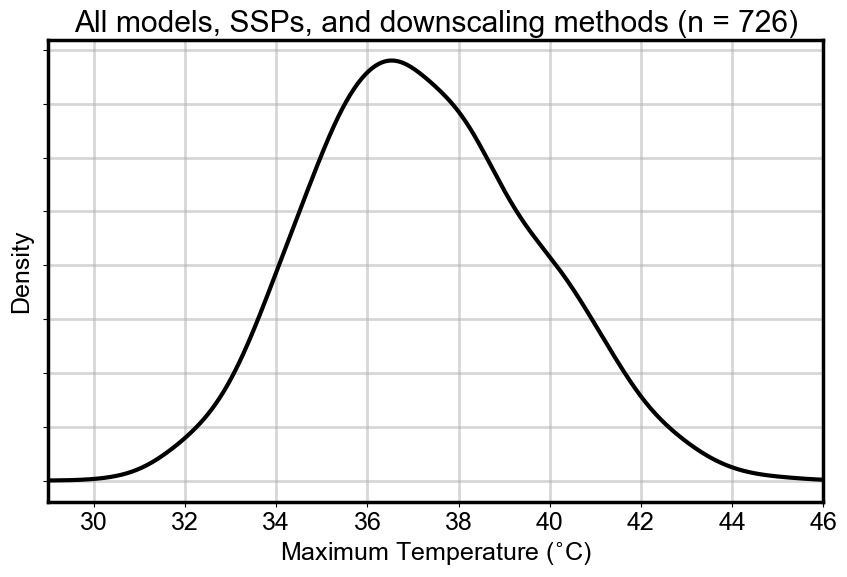

In [32]:
# Raw plot
fig, ax = plt.subplots(figsize=(10, 6))

df_mid[var_id].plot.kde(ax=ax, color="black", lw=3)

ax.set_title("All models, SSPs, and downscaling methods (n = " + str(len(df_mid)) + ")")
ax.set_xlabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlim([29, 46])
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.savefig(
    "../figs/supplementary/timeseries/Chicago_max_" + var_id + "_raw.png", dpi=600
)

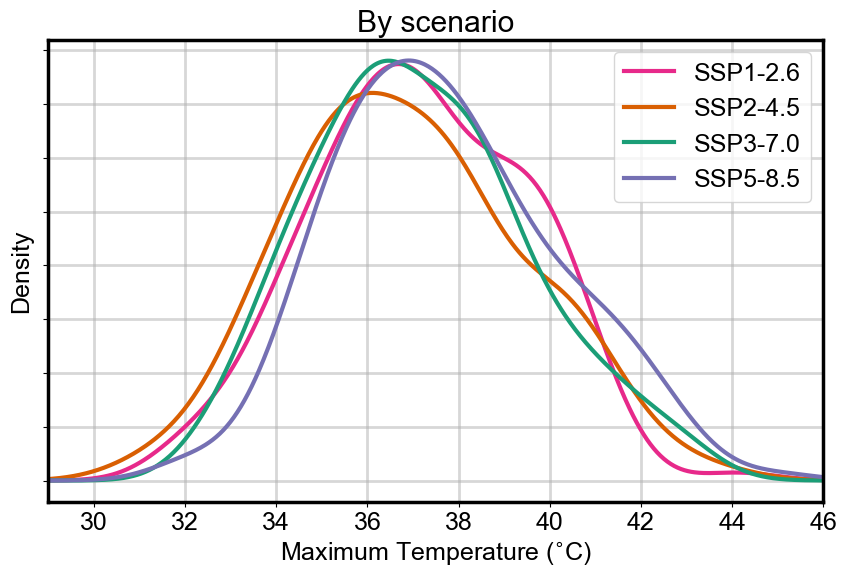

In [29]:
# SSP plot
ssp_color_dict = {
    "ssp126": "#e7298a",
    "ssp245": "#d95f02",
    "ssp370": "#1b9e77",
    "ssp585": "#7570b3",
}

fig, ax = plt.subplots(figsize=(10, 6))

df_mid.query('ssp == "ssp126"')[var_id].plot.kde(
    ax=ax, color=ssp_color_dict["ssp126"], label="SSP1-2.6", lw=3
)
df_mid.query('ssp == "ssp245"')[var_id].plot.kde(
    ax=ax, color=ssp_color_dict["ssp245"], label="SSP2-4.5", lw=3
)
df_mid.query('ssp == "ssp370"')[var_id].plot.kde(
    ax=ax, color=ssp_color_dict["ssp370"], label="SSP3-7.0", lw=3
)
df_mid.query('ssp == "ssp585"')[var_id].plot.kde(
    ax=ax, color=ssp_color_dict["ssp585"], label="SSP5-8.5", lw=3
)

ax.set_title("By scenario")
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlim([29, 46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig(
    "../figs/supplementary/timeseries/Chicago_max_" + var_id + "_ssp.png", dpi=600
)

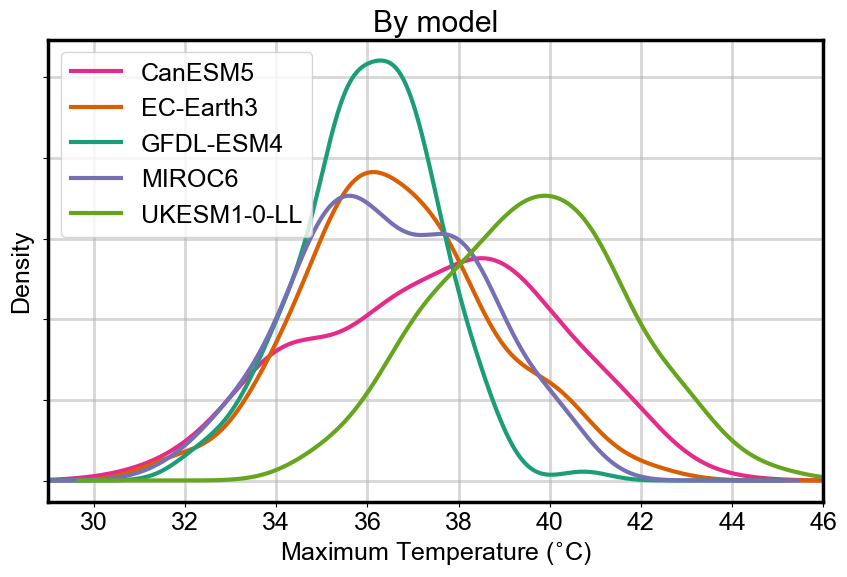

In [33]:
# Model plot
# models = reduce(lambda a, b: np.unique(np.append(a,b)), [nex_models, cil_models, isi_models])
model_color_dict = {
    models[0]: "#e7298a",
    models[1]: "#d95f02",
    models[2]: "#1b9e77",
    models[3]: "#7570b3",
    models[4]: "#66a61e",
}

fig, ax = plt.subplots(figsize=(10, 6))

for model in models:
    df_mid[df_mid.model == model][var_id].plot.kde(
        ax=ax, color=model_color_dict[model], lw=3, label=model
    )

ax.set_title("By model")
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlim([29, 46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig(
    "../figs/supplementary/timeseries/Chicago_max_" + var_id + "_models.png", dpi=600
)

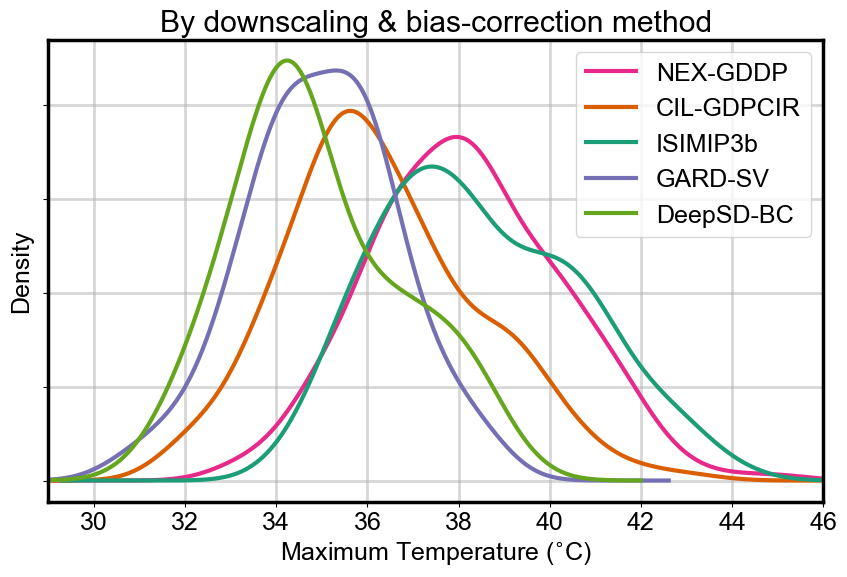

In [31]:
# Ensemble plot
ens_color_dict = {
    "NEX": "#e7298a",
    "CIL": "#d95f02",
    "ISIMIP": "#1b9e77",
    "GARD-SV": "#7570b3",
    "DeepSD-BC": "#66a61e",
}

fig, ax = plt.subplots(figsize=(10, 6))

df_mid.query('ensemble == "NEX"')[var_id].plot.kde(
    ax=ax, color=ens_color_dict["NEX"], label="NEX-GDDP", lw=3
)
df_mid.query('ensemble == "CIL"')[var_id].plot.kde(
    ax=ax, color=ens_color_dict["CIL"], label="CIL-GDPCIR", lw=3
)
df_mid.query('ensemble == "ISIMIP"')[var_id].plot.kde(
    ax=ax, color=ens_color_dict["ISIMIP"], label="ISIMIP3b", lw=3
)
df_mid.query('ensemble == "GARD-SV"')[var_id].plot.kde(
    ax=ax, color=ens_color_dict["GARD-SV"], label="GARD-SV", lw=3
)
df_mid.query('ensemble == "DeepSD-BC"')[var_id].plot.kde(
    ax=ax, color=ens_color_dict["DeepSD-BC"], label="DeepSD-BC", lw=3
)

ax.set_title("By downscaling & bias-correction method")
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlim([29, 46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig(
    "../figs/supplementary/timeseries/Chicago_max_" + var_id + "_ens.png", dpi=600
)

### Timeseries

In [35]:
# Chicago, IL
lat, lon = 41.882, -87.628

# Metric
var_id = "tasmax"

In [ ]:
# Read all combinations
df = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

# NEX
for model in nex_models:
    df_tmp = read_and_process("NEX", nex_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# CIL
for model in cil_models:
    df_tmp = read_and_process("CIL", cil_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# ISIMIP
for model in isi_models:
    df_tmp = read_and_process("ISIMIP", isi_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# GARD-SV
for model in cbp_gard_models:
    df_tmp = read_and_process(
        "GARD-SV",
        cbp_in + "/regridded/conservative/GARD-SV/",
        model,
        "max",
        var_id,
        False,
        lat,
        lon,
    )
    df = pd.concat([df, df_tmp])

# DeepSD-BC
for model in cbp_deep_models:
    df_tmp = read_and_process(
        "DeepSD-BC",
        cbp_in + "native_grid/DeepSD-BC/",
        model,
        "max",
        var_id,
        False,
        lat,
        lon,
    )
    df = pd.concat([df, df_tmp])

In [67]:
# Read all combinations
df_forced = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

# NEX
for model in nex_models:
    df_tmp = read_and_process_forced(
        "NEX", poly_path, model, "max", var_id, False, lat, lon
    )
    df_forced = pd.concat([df_forced, df_tmp])

# CIL
for model in cil_models:
    df_tmp = read_and_process_forced(
        "CIL", poly_path, model, "max", var_id, False, lat, lon
    )
    df_forced = pd.concat([df_forced, df_tmp])

# ISIMIP
for model in isi_models:
    df_tmp = read_and_process_forced(
        "ISIMIP", poly_path, model, "max", var_id, False, lat, lon
    )
    df_forced = pd.concat([df_forced, df_tmp])

# GARD-SV
for model in cbp_gard_models:
    df_tmp = read_and_process_forced(
        "GARD-SV", poly_path, model, "max", var_id, False, lat, lon
    )
    df_forced = pd.concat([df_forced, df_tmp])

# DeepSD-BC
for model in cbp_deep_models:
    df_tmp = read_and_process_forced(
        "DeepSD-BC", poly_path, model, "max", var_id, False, lat, lon
    )
    df_forced = pd.concat([df_forced, df_tmp])

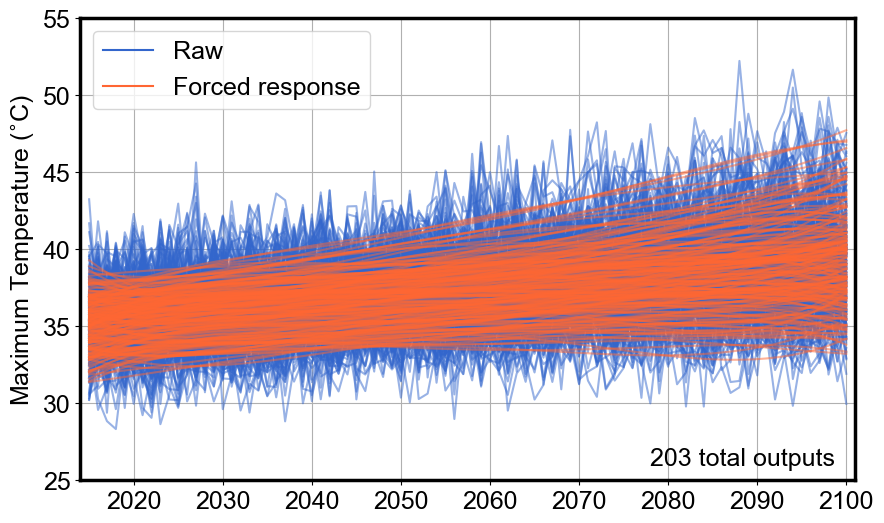

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot([1, 2], [3, 4], color="#3366CC", label="Raw")
ax.plot([1, 2], [3, 4], color="#FF6633", label="Forced response")
ax.legend()

df.groupby(["ensemble", "model", "ssp"]).plot(
    x="time", y=var_id, alpha=0.5, color="#3366CC", ax=ax, legend=None
)
df_forced.groupby(["ensemble", "model", "ssp"]).plot(
    x="time", y=var_id, alpha=0.5, color="#FF6633", ax=ax, legend=None
)

ax.set_ylabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlabel("")
ax.text(2078, 26, str(len(df[df.time == 2050])) + " total outputs")
ax.grid()
ax.set_xlim([2014, 2101])
ax.set_ylim([25, 55])
plt.savefig("../figs/supplementary/timeseries/Chicago_max_tasmax.png", dpi=800)

In [36]:
# Single example
df = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

# Raw
for model in nex_models[:1]:
    df_tmp = read_and_process("NEX", nex_in, model, "max", var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

# Forced
df_forced = pd.DataFrame(columns=["time", "model", "ensemble", "ssp", var_id])

for model in nex_models[:1]:
    df_tmp = read_and_process_forced(
        "NEX", poly_path, model, "max", var_id, False, lat, lon
    )
    df_forced = pd.concat([df_forced, df_tmp])

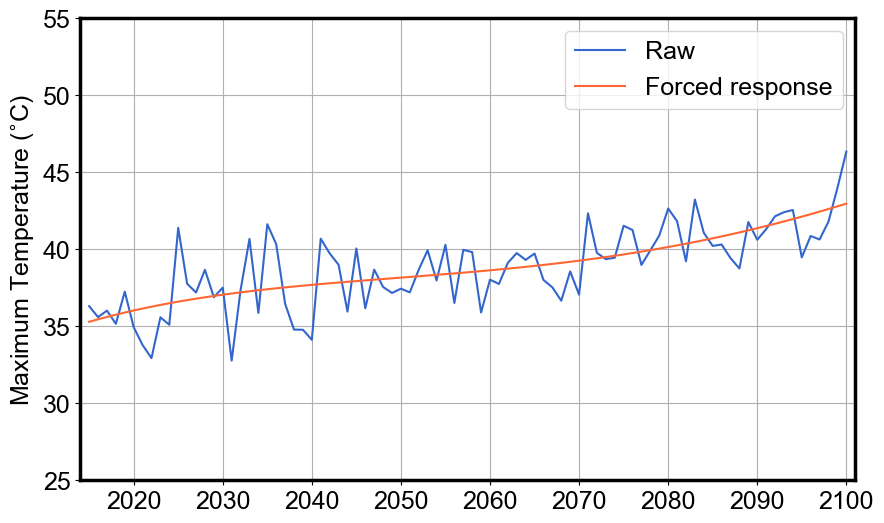

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot([1, 2], [3, 4], color="#3366CC", label="Raw")
ax.plot([1, 2], [3, 4], color="#FF6633", label="Forced response")
ax.legend()

ssp = "ssp585"
df[df.ssp == ssp].plot(x="time", y=var_id, alpha=1, color="#3366CC", ax=ax, legend=None)
df_forced[df_forced.ssp == ssp].plot(
    x="time", y=var_id, alpha=1, color="#FF6633", ax=ax, legend=None
)

ax.set_ylabel("Maximum Temperature ($\!^\circ\!$C)")
ax.set_xlabel("")
ax.grid()
ax.set_xlim([2014, 2101])
ax.set_ylim([25, 55])
plt.savefig("../figs/supplementary/timeseries/Chicago_max_tasmax_single.png", dpi=800)
# plt.show()